In [1]:
import os
from typing import List
from pathlib import Path

import cv2
import numpy as np


IMAGES_FOLDER_PATH = "original_size_images_2"
RESIZED_IMAGES_FOLDER_PATH = "resized_images"
PROCESSED_IMAGES_PATH= "processed_images"
TARGET_WIDTH = 1920

Path(IMAGES_FOLDER_PATH).mkdir(exist_ok=True)
Path(RESIZED_IMAGES_FOLDER_PATH).mkdir(exist_ok=True)
Path(PROCESSED_IMAGES_PATH).mkdir(exist_ok=True)


def get_images_from_folder(images_path: str) -> List[str]:
    image_extensions = ["jpg", "jpeg", "png", "gif", "bmp"]
    return [file for file in os.listdir(images_path) if file.lower().split(".")[-1] in image_extensions]


def resize_image(image: np.ndarray) -> np.ndarray:
    original_height, original_width = image.shape[:2]
    proportional_height = int((TARGET_WIDTH / original_width) * original_height)
    return cv2.resize(image, (TARGET_WIDTH, proportional_height))


images_in_folder = sorted(get_images_from_folder(IMAGES_FOLDER_PATH))


## To begin, let's resize our images.
## Since it's a bit resource-consuming task, we'll do this before jumping into the fun stuff with our images 😉

In [2]:
from concurrent.futures import ThreadPoolExecutor


def resize_and_save(image_name: str) -> None:
    image = resize_image(cv2.imread("/".join([IMAGES_FOLDER_PATH, image_name])))
    cv2.imwrite("/".join([RESIZED_IMAGES_FOLDER_PATH, image_name]), image)


with ThreadPoolExecutor(max_workers=8) as executor:
    results = executor.map(resize_and_save, images_in_folder)


## Moving on, let's create the timelapse video without any preprocessing magic.
## This will help us identify the issues that we'll address later on.

In [3]:
images_in_memory = [
    cv2.imread("/".join([RESIZED_IMAGES_FOLDER_PATH, i]))
    for i in sorted(get_images_from_folder(RESIZED_IMAGES_FOLDER_PATH))
]

In [4]:
height, width, _ = images_in_memory[0].shape
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video = cv2.VideoWriter("before_processing.mp4", fourcc, 24, (width, height))

for image in images_in_memory:
    video.write(image)
video.release()


## For a visual representation of brightness distribution across all images, let's construct a plot.

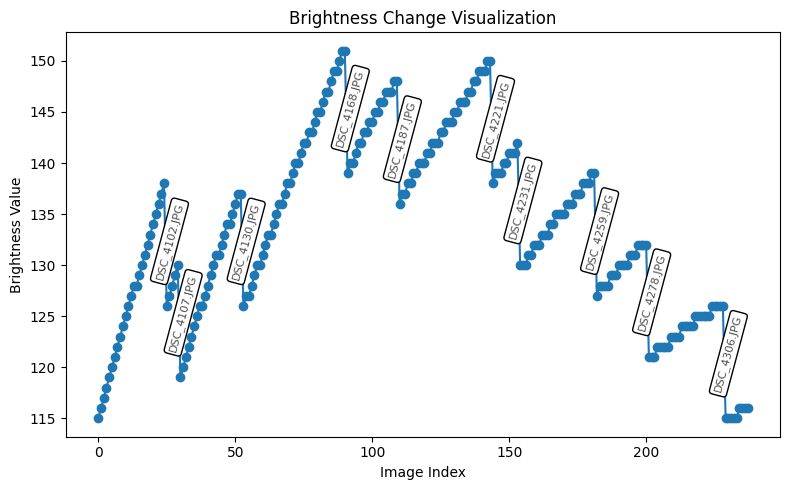

In [8]:
import matplotlib.pyplot as plt

THRESHOLD = 8.0
plt.figure(figsize=(8, 5))


def calculate_image_brightness(image: np.ndarray) -> float:
    image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.median(image_grayscale)


brightness_values = []
previous_brightness_value = None
for i in range(len(images_in_memory)):
    if not previous_brightness_value:
        previous_brightness_value = calculate_image_brightness(images_in_memory[i])
        continue

    brightness_value = calculate_image_brightness(images_in_memory[i])
    brightness_values.append(brightness_value)
    if abs(brightness_value - previous_brightness_value) > THRESHOLD:
        plt.annotate(
            images_in_folder[i],
            (i, brightness_value),
            textcoords="offset points",
            xytext=(0, 20),
            ha="center",
            bbox=dict(
                boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"
            ),
            fontsize=8,
            alpha=0.7,
            rotation=75
        )
    previous_brightness_value = brightness_value

plt.plot(brightness_values)
plt.xlabel("Image Index")
plt.ylabel("Brightness Value")
plt.title("Brightness Change Visualization")


## There are three dips in the plot, each corresponding to images with visible changes in brightness. Let's focus on the first image and enhance its brightness using a histogram matching approach.
## Let's calculate a histogram for each image and compare them:

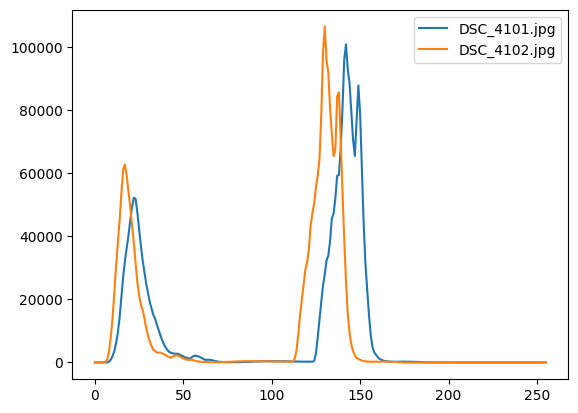

In [9]:
img1_name = "DSC_4101.jpg"
img2_name = "DSC_4102.jpg"

img1 = cv2.imread(f"{RESIZED_IMAGES_FOLDER_PATH}/{img1_name}")
img2 = cv2.imread(f"{RESIZED_IMAGES_FOLDER_PATH}/{img2_name}")

grayscale1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
grayscale2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

hist1 = cv2.calcHist([grayscale1], [0], None, [256], [0, 256])
hist2 = cv2.calcHist([grayscale2], [0], None, [256], [0, 256])

plt.plot(hist1, label=img1_name)
plt.legend()
plt.plot(hist2, label=img2_name)
plt.legend()


## You can observe the disparity between these histograms — a darker image has more pixels with smaller values.
### Now, using the reference histogram, we need to update the pixel intensity values in the input picture such that they match.

## Histogram Matching Function

1. **Compute Histograms:** Calculate histograms for the reference and target images.

2. **Calculate and Normalize CDFs:** Compute Cumulative Distribution Functions (CDFs) for the histograms.

3. **Mapping Function:** For each gray level in the reference image, find the corresponding level in the target image.

4. **Apply Mapping Function:** Create a mapping function and apply it to each pixel in the reference image.


True

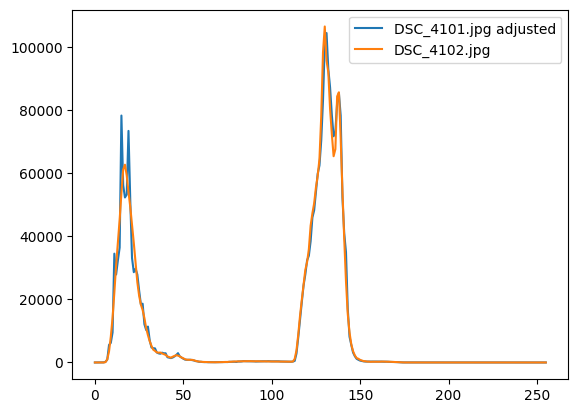

In [11]:
def histogram_matching(reference_img, target_img):
    hist_ref, _ = np.histogram(reference_img, 256, [0, 256])
    hist_target, _= np.histogram(target_img, 256, [0, 256])

    cdf_ref = hist_ref.cumsum()
    cdf_target = hist_target.cumsum()
    cdf_ref_normalized = cdf_ref / cdf_ref[-1]
    cdf_target_normalized = cdf_target / cdf_target[-1]

    M_mapping = np.zeros(256, dtype=np.uint8)
    for G1 in range(256):
        G2 = np.argmin(np.abs(cdf_ref_normalized[G1] - cdf_target_normalized))
        M_mapping[G1] = G2

    matched_img = M_mapping[reference_img]

    return matched_img

matched = histogram_matching(img1, img2)
matched = matched.astype(np.uint8)

matched_grayscale = cv2.cvtColor(matched, cv2.COLOR_BGR2GRAY)
hist_matched = cv2.calcHist([matched_grayscale], [0], None, [256], [0, 256])

plt.plot(hist_matched, label=f"{img1_name} adjusted")
plt.legend()
plt.plot(hist2, label=img2_name)
plt.legend()

cv2.imwrite(f"{PROCESSED_IMAGES_PATH}/{img1_name}", matched)
cv2.imwrite(f"{PROCESSED_IMAGES_PATH}/{img2_name}", img2)
None

## Excellent outcome! Now, let's apply this solution to our footage. Although we can adjust our images differently, for the sake of simplicity, we'll use the latest image with visible brightness difference as a target and apply brightness adjustments to all preceding images, ensuring consistent brightness throughout the video.
## Feel free to experiment with different approaches for varied results 👩‍🔬

In [12]:
from tqdm.notebook import tqdm


THRESHOLD = 8.0


def calculate_exposure_difference(image1: np.ndarray, image2: np.ndarray) -> float:
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    return np.median(gray2.astype(np.int16) - gray1.astype(np.int16))


reference_image_index = None
for i in range(1, len(images_in_memory)):
    exposure_difference = calculate_exposure_difference(images_in_memory[i - 1], images_in_memory[i])
    if abs(exposure_difference) > THRESHOLD:
        print(f"images {images_in_folder[i - 1]} and {images_in_folder[i]} have {exposure_difference} brightness difference")
        reference_image_index = i


for i in tqdm(range(reference_image_index)):
    # To prevent unnecessary enormous RAM usage, we need to convert these NumPy arrays to uint8.
    adjusted_image = histogram_matching(images_in_memory[i], images_in_memory[reference_image_index]).astype(np.uint8)
    images_in_memory[i] = adjusted_image


images DSC_4101.JPG and DSC_4102.JPG have -11.0 brightness difference
images DSC_4106.JPG and DSC_4107.JPG have -11.0 brightness difference
images DSC_4129.JPG and DSC_4130.JPG have -11.0 brightness difference
images DSC_4167.JPG and DSC_4168.JPG have -11.0 brightness difference
images DSC_4186.JPG and DSC_4187.JPG have -12.0 brightness difference
images DSC_4220.JPG and DSC_4221.JPG have -12.0 brightness difference
images DSC_4230.JPG and DSC_4231.JPG have -12.0 brightness difference
images DSC_4258.JPG and DSC_4259.JPG have -11.0 brightness difference
images DSC_4277.JPG and DSC_4278.JPG have -11.0 brightness difference
images DSC_4305.JPG and DSC_4306.JPG have -11.0 brightness difference


  0%|          | 0/230 [00:00<?, ?it/s]

## And now, let's see how it turned out! ✨

In [35]:
height, width, _ = images_in_memory[0].shape

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video = cv2.VideoWriter("adjusted_video.mp4", fourcc, 24, (width, height))

for image in images_in_memory:
    video.write(image)
video.release()
